Plot depth-averaged MMT.

In [10]:
import numpy as np
import xarray as xr
import cmocean as cmocean
import numpy.linalg as la
from scipy.io import netcdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from xgcm import Grid
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from matplotlib.colors import SymLogNorm, BoundaryNorm, LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import MaxNLocator


mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [6]:
# Snapshot
root = '/scratch/mp6191/NW2_TracerBackscatter'

exp = '/p5_noBS_KHTR0_2'
p5_noBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1.load()
p5_noBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2.load()
p5_noBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p5_noBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time').load()
p5_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)

exp = '/p5_SQGBS_KHTR0_2'
p5_SQGBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1.load()
p5_SQGBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2.load()
p5_SQGBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p5_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time').load()

exp = '/p25_noBS_2'
p25_noBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1.load()
p25_noBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2.load()
p25_noBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p25_noBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time').load()
p25_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)

exp = '/p25_SQGBS_2'
p25_SQGBS_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1.load()
p25_SQGBS_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2.load()
p25_SQGBS_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p25_SQGBS_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time').load()

exp = '/p03125_2'
p03125 = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False)
p03125_kappa1 = xr.open_dataset(root + exp + '/MMT_kappa1_corr.nc', decode_times = False).kappa1.load()
p03125_kappa2 = xr.open_dataset(root + exp + '/MMT_kappa2_corr.nc', decode_times = False).kappa2.load()
p03125_K = xr.open_dataset(root + exp + '/MMT_fullK_corr.nc', decode_times = False)['full K'].load()
p03125_h = xr.open_mfdataset(root + exp + '/MMT_fields*.nc', decode_times = False).h.mean('time').load()
p03125_static = xr.open_dataset(root + exp + '/static.nc', decode_times = False)

# Grid
p5_grid = Grid(p5_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                    'Y': {'center': 'yh', 'outer': 'yq'}}, periodic = ['X'])

p25_grid = Grid(p25_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                      'Y': {'center': 'yh', 'outer': 'yq'}}, periodic = ['X'])

p03125_grid = Grid(p03125_static, coords = {'X': {'center': 'xh', 'outer': 'xq'},
                                            'Y': {'center': 'yh', 'outer': 'yq'}}, periodic = ['X'])

/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ext3/miniconda3/lib/python3.10/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Ser

In [7]:
def calc_streamfunc(ds, grid):
    uh = grid.interp(ds.uh.mean('time'), axis = 'X')

    verticalsum = uh.sum('zl')
    int_from_right = (- (verticalsum).cumsum(dim = 'yh') + (verticalsum).sum(dim = 'yh'))
    mag = int_from_right / 1e6

    return mag.load()

def calc_eigvecs(K):
    K_T = np.moveaxis(K.values, -2, -1)
    S = 0.5 * (K.values + K_T)

    evecs = xr.zeros_like(K)
    x, y, z = evecs.shape[0], evecs.shape[1], evecs.shape[2]

    for i in range(x):
        for j in range(y):
            for k in range(z):
                eigvals, eigvecs = la.eig(S[i, j, k, :, :])

                indmax = np.abs(eigvals).argmax()
                indmin = np.abs(eigvals).argmin()

                evecs[i, j, k][:, 0] = eigvecs[:, indmax]
                evecs[i, j, k][:, 1] = eigvecs[:, indmin]

    return evecs

def depth_integrate_kappa(kappa, h, res):

    coarsen_scale = int(2 / res)
    h_coarsen = h.coarsen(xh = coarsen_scale, yh = coarsen_scale, boundary = 'exact').mean()

    kappa_int = (kappa * h_coarsen).sum('zl') / h_coarsen.sum('zl')

    return kappa_int.load()

### Plot

In [4]:
streamfunc = calc_streamfunc(p03125, p03125_grid)
evecs = calc_eigvecs(p03125_K)
evecs_maj = evecs.isel(col = 0)
evecs_min = evecs.isel(col = 1)
h_coarse = p03125_h.coarsen(xh = int(2 / 0.03125), yh = int(2 / 0.03125), boundary = 'exact').mean()

/ext3/miniconda3/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2157: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2157: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


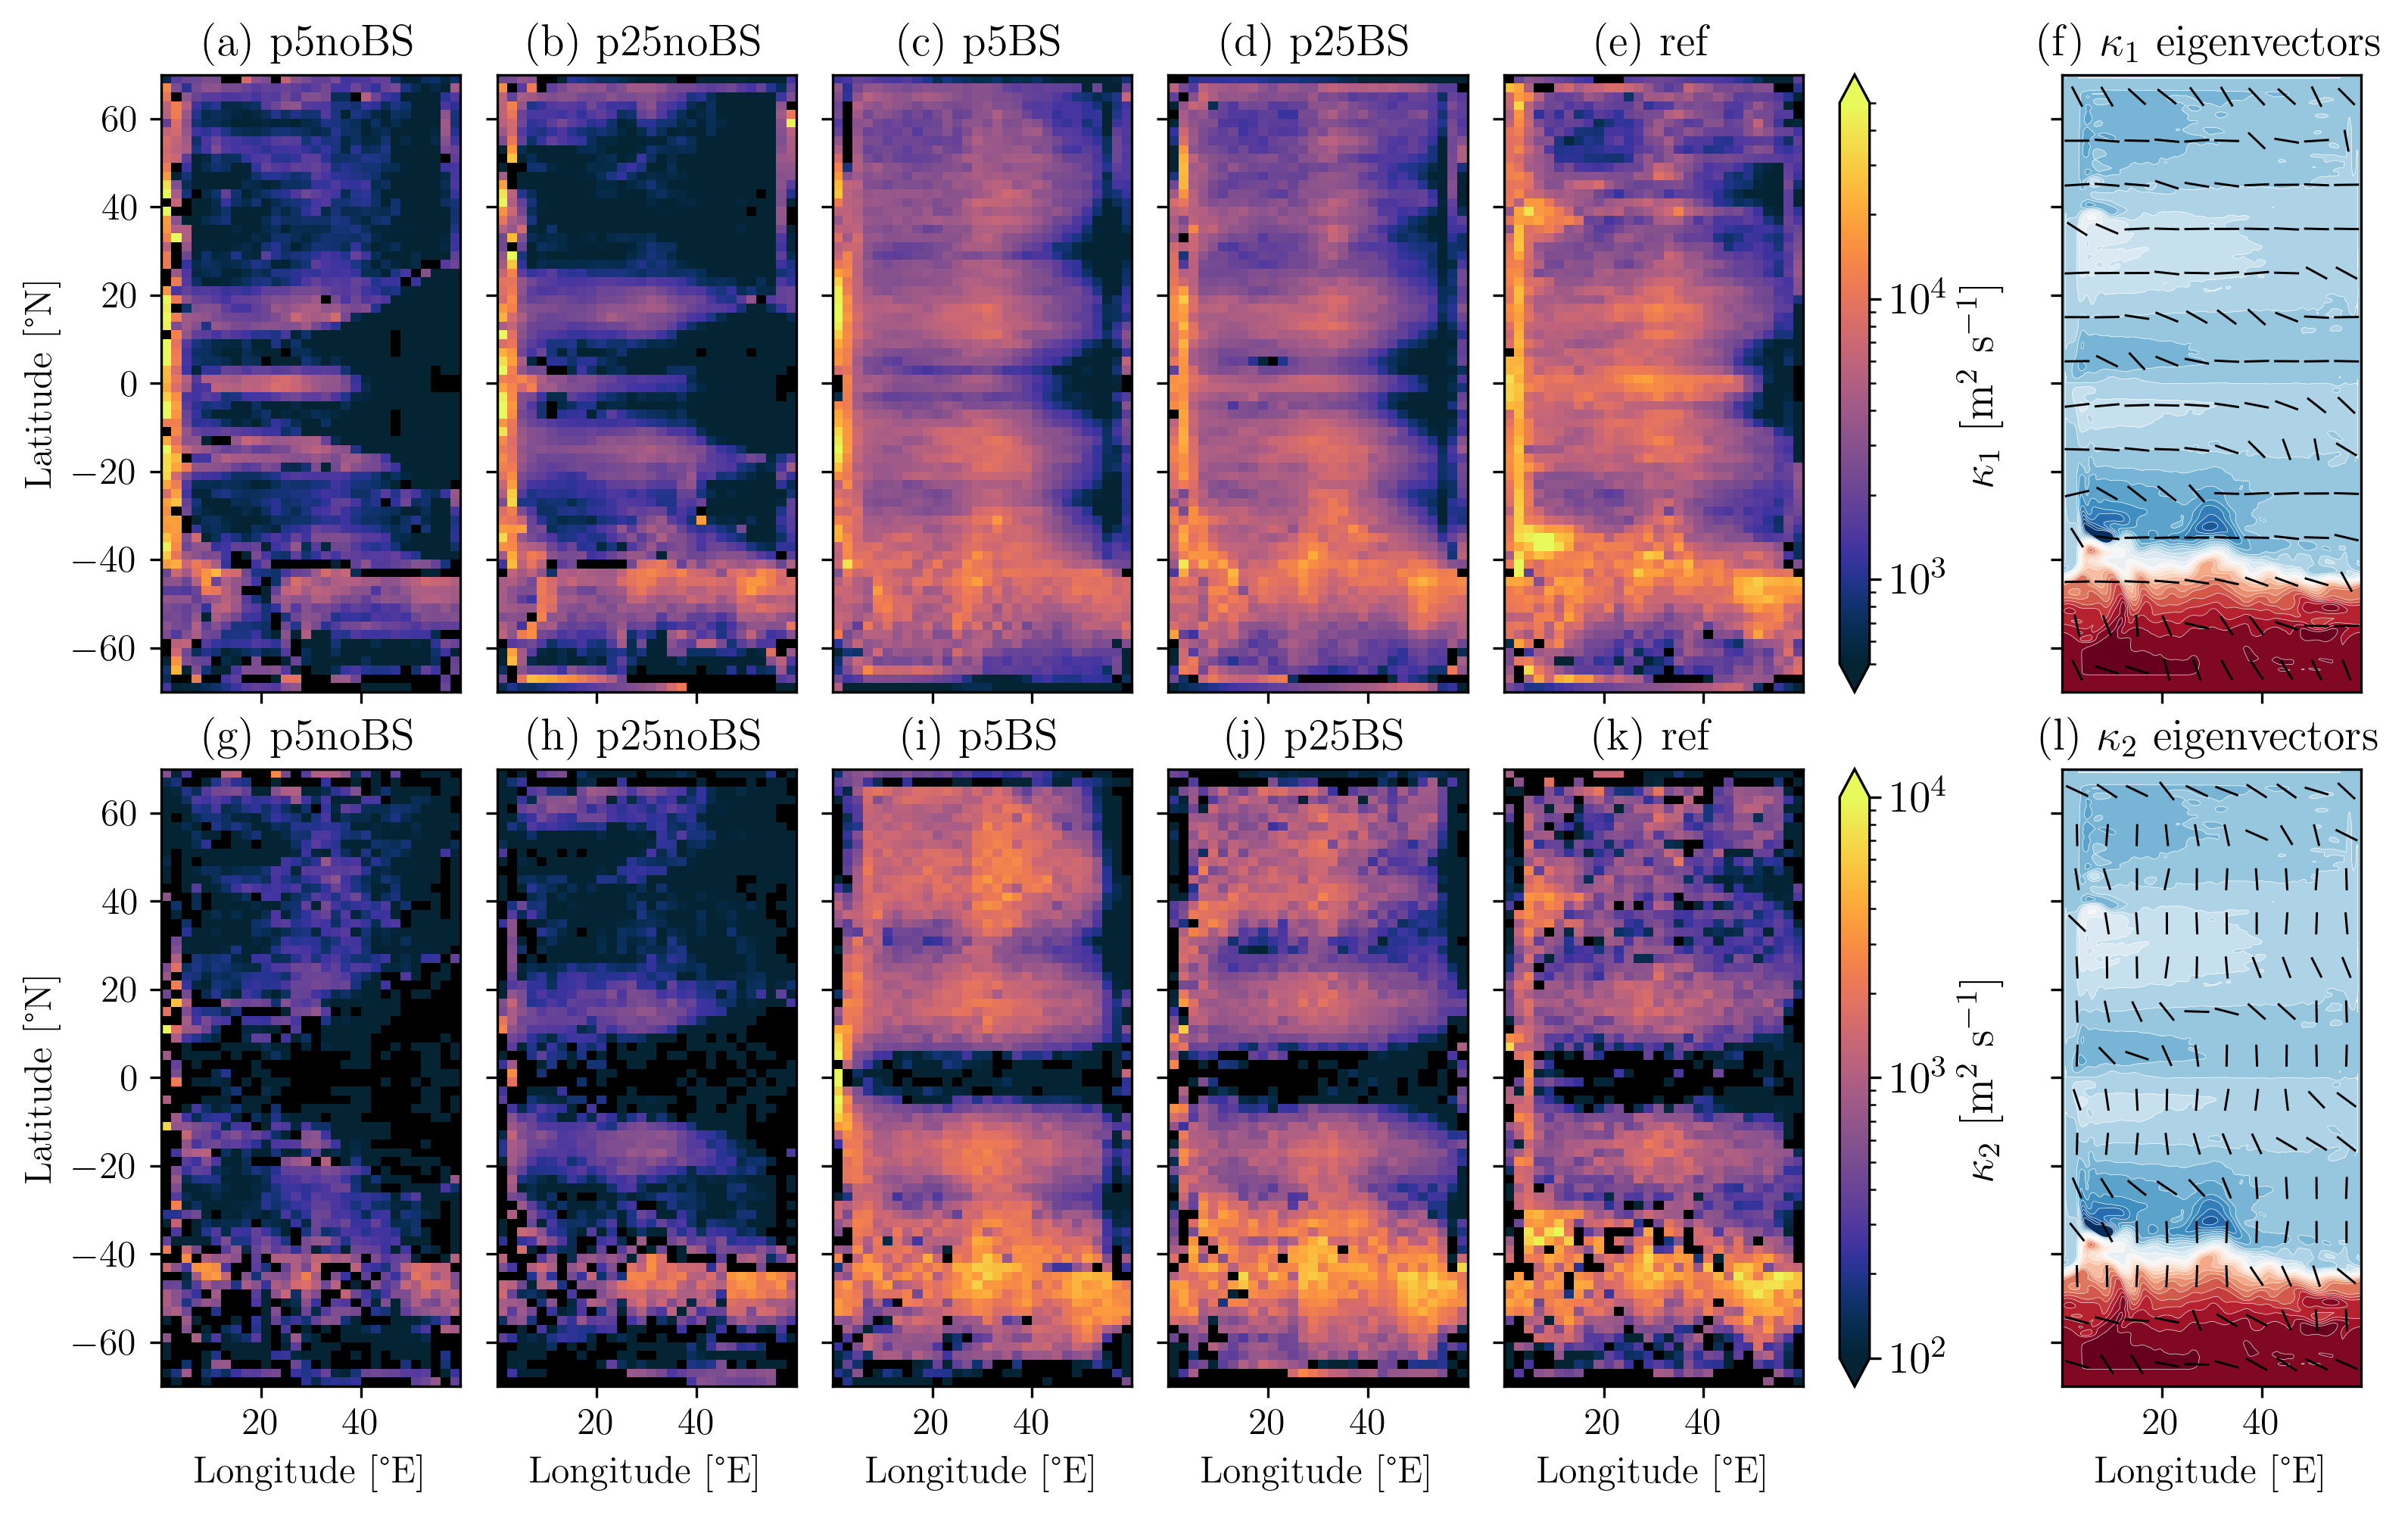

In [17]:
# Create figure
fig = plt.figure(figsize = (12.5, 7.5), dpi = 300)  # increased height for new row
gs = gridspec.GridSpec(2, 8, width_ratios = [1, 1, 1, 1, 1, 0.1, 0.4, 1], height_ratios = [1, 1], wspace = 0.15, hspace = 0.125)
fontsize = 14
zl = 15

# First row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[0, 4])
cbar_ax_1 = fig.add_subplot(gs[0, 5])
ax6 = fig.add_subplot(gs[0, 7])

# Second row
ax7 = fig.add_subplot(gs[1, 0])
ax8 = fig.add_subplot(gs[1, 1])
ax9 = fig.add_subplot(gs[1, 2])
ax10 = fig.add_subplot(gs[1, 3])
ax11 = fig.add_subplot(gs[1, 4])
cbar_ax_2 = fig.add_subplot(gs[1, 5])
ax12 = fig.add_subplot(gs[1, 7])

# kappa1
vmin = 5e2
vmax = 5e4
cmap = cmocean.cm.thermal
cmap.set_bad(color='k')
norm = LogNorm(vmin = vmin, vmax = vmax)

ax = ax1
ax.set_facecolor('k')
ds = depth_integrate_kappa(p5_noBS_kappa1, p5_noBS_h, 1/2)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(a) p5noBS', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('Latitude [°N]', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax2
ax.set_facecolor('k')
ds = depth_integrate_kappa(p25_noBS_kappa1, p25_noBS_h, 1/4)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(b) p25noBS', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax3
ax.set_facecolor('k')
ds = depth_integrate_kappa(p5_SQGBS_kappa1, p5_SQGBS_h, 1/2)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(c) p5BS', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax4
ax.set_facecolor('k')
ds = depth_integrate_kappa(p25_SQGBS_kappa1, p25_SQGBS_h, 1/4)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(d) p25BS', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax5
ax.set_facecolor('k')
ds = depth_integrate_kappa(p03125_kappa1, p03125_h, 1/32)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(e) ref', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

#Add colorbar
cbar = fig.colorbar(plotted, cax = cbar_ax_1, extend = 'both')
cbar.set_label(r'$\kappa_1$ [m$^2$ s$^{-1}$]', fontsize = fontsize, labelpad = 2)
cbar.ax.tick_params(labelsize = fontsize)

ax = ax6
vmin = -80
vmax = 250
vtrans = 20
levs1 = np.arange(vmin, vtrans, 10)
levs2 = np.arange(vtrans, vmax, 15)
levs = np.concatenate([levs1, levs2])
streamfunc_plot = streamfunc.plot.contourf(ax = ax, vmin = vmin, vmax = vmax, levels = levs, cmap = 'RdBu_r', linewidths = 0.35, linestyles = np.where(levs > 0, '-', '-'), zorder = 1, add_colorbar = False)
streamfunc.plot.contour(ax = ax, vmin = vmin, vmax = vmax, levels = levs, colors = 'white', linewidths = 0.15, linestyles = np.where(levs > 0, '-', '-'), zorder = 1)

x_coarsen = 3
y_coarsen = 5
ds = ((evecs_maj.isel(zl = slice(0, zl)) * h_coarse.isel(zl = slice(0, zl))).sum('zl') / h_coarse.isel(zl = slice(0, zl)).sum('zl')).coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean()
#ds = evecs_maj.isel(zl = zl).coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean()
x, y = evecs_maj.mean('zl').coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean().xh, evecs_min.mean('zl').coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean().yh
xx, yy = np.meshgrid(x, y)
U = ds.isel(row = 0)
V = ds.isel(row = 1)
mag = np.sqrt(U ** 2 + V ** 2)
ax.quiver(xx, yy, U / mag, V / mag, color = 'k', angles = 'xy', scale_units = 'xy', scale = 0.2, headlength = 0, headwidth = 0, headaxislength = 0, pivot = 'middle', alpha = 1., zorder = 2, width = 0.0075)
ax.set_title(f'(f) $\kappa_1$ eigenvectors', fontsize = fontsize)
ax.set_xlabel('', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

# Hide duplicate tick labels for a cleaner look
ax1.tick_params(labelbottom = False)
ax2.tick_params(labelleft = False, labelbottom = False)
ax3.tick_params(labelleft = False, labelbottom = False)
ax4.tick_params(labelleft = False, labelbottom = False)
ax5.tick_params(labelleft = False, labelbottom = False)
ax6.tick_params(labelleft = False, labelbottom = False)

# kappa2
vmin = 1e2
vmax = 1e4
cmap = cmocean.cm.thermal
cmap.set_bad(color='k')
norm = LogNorm(vmin = vmin, vmax = vmax)

ax = ax7
ax.set_facecolor('k')
ds = depth_integrate_kappa(p5_noBS_kappa2, p5_noBS_h, 1/2)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(g) p5noBS', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('Latitude [°N]', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))   

ax = ax8
ax.set_facecolor('k')
ds = depth_integrate_kappa(p25_noBS_kappa2, p25_noBS_h, 1/4)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(h) p25noBS', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))   

ax = ax9
ax.set_facecolor('k')
ds = depth_integrate_kappa(p5_SQGBS_kappa2, p5_SQGBS_h, 1/2)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(i) p5BS', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax10
ax.set_facecolor('k')
ds = depth_integrate_kappa(p25_SQGBS_kappa2, p25_SQGBS_h, 1/4)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(j) p25BS', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

ax = ax11
ax.set_facecolor('k')
ds = depth_integrate_kappa(p03125_kappa2, p03125_h, 1/32)
ds = ds.where(ds >= 0, np.nan)
plotted = ax.pcolormesh(ds.xh, ds.yh, ds.T, cmap = cmap, norm = norm)
ax.set_title(f'(k) ref', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

#Add colorbar
cbar = fig.colorbar(plotted, cax = cbar_ax_2, extend = 'both')
cbar.set_label(r'$\kappa_2$ [m$^2$ s$^{-1}$]', fontsize = fontsize, labelpad = 2)
cbar.ax.tick_params(labelsize = fontsize)

ax = ax12
streamfunc_plot = streamfunc.plot.contourf(ax = ax, vmin = vmin, vmax = vmax, levels = levs, cmap = 'RdBu_r', linewidths = 0.35, linestyles = np.where(levs > 0, '-', '-'), zorder = 1, add_colorbar = False)
streamfunc.plot.contour(ax = ax, vmin = vmin, vmax = vmax, levels = levs, colors = 'white', linewidths = 0.15, linestyles = np.where(levs > 0, '-', '-'), zorder = 1)

x_coarsen = 3
y_coarsen = 5
ds = ((evecs_min.isel(zl = slice(0, zl)) * h_coarse.isel(zl = slice(0, zl))).sum('zl') / h_coarse.isel(zl = slice(0, zl)).sum('zl')).coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean()
x, y = evecs_min.mean('zl').coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean().xh, evecs_min.mean('zl').coarsen(xh = x_coarsen, yh = y_coarsen, boundary = 'exact').mean().yh
xx, yy = np.meshgrid(x, y)
U = ds.isel(row = 0)
V = ds.isel(row = 1)
mag = np.sqrt(U ** 2 + V ** 2)
ax.quiver(xx, yy, U / mag, V / mag, color = 'k', angles = 'xy', scale_units = 'xy', scale = 0.2, headlength = 0, headwidth = 0, headaxislength = 0, pivot = 'middle', alpha = 1., zorder = 2, width = 0.0075)
ax.set_title(f'(l) $\kappa_2$ eigenvectors', fontsize = fontsize)
ax.set_xlabel('Longitude [°E]', fontsize = fontsize - 2)
ax.set_ylabel('', fontsize = fontsize - 2)
ax.tick_params(labelsize = fontsize - 2)
ax.set_xticks(np.linspace(20, 40, 2))

# Hide duplicate tick labels for a cleaner look
ax8.tick_params(labelleft = False)
ax9.tick_params(labelleft = False)
ax10.tick_params(labelleft = False)
ax11.tick_params(labelleft = False)
ax12.tick_params(labelleft = False)

plt.savefig('Fig_depth_ave_MMT.png', bbox_inches = 'tight', dpi = 300)